In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import os
import sys
#scripts_path = os.path.basename(os.path.abspath(__file__))
#scripts_path = os.path.basename(scripts_path)
#scripts_path = os.path.join(scripts_path, "scripts")
scripts_path = "/home/joao/Documentos/repos/renewable-generation-into-reserve-markets/scripts"
sys.path.append(scripts_path)

from predictions_scores import prediction_score, save_scores

# Read data
dataset = pd.read_csv('../data/dados_2014-2022.csv', index_col=0)
original_dataset = dataset.copy()
datetime_col = "datetime"
d = pd.to_datetime(dataset[datetime_col], format="mixed")
original_dataset[datetime_col] = d
original_dataset = original_dataset.set_index('datetime')

d = pd.to_datetime(dataset["datetime"], format="mixed", utc=True)

dataset.index = d
dataset.drop("datetime", axis=1, inplace=True)
# Impute missing values
imputer = IterativeImputer(max_iter=10, random_state=0)
df_imputed = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns, index=dataset.index)


/tmp/ipykernel_2839/3916156602.py:25: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise a warning unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  d = pd.to_datetime(dataset[datetime_col], format="mixed")


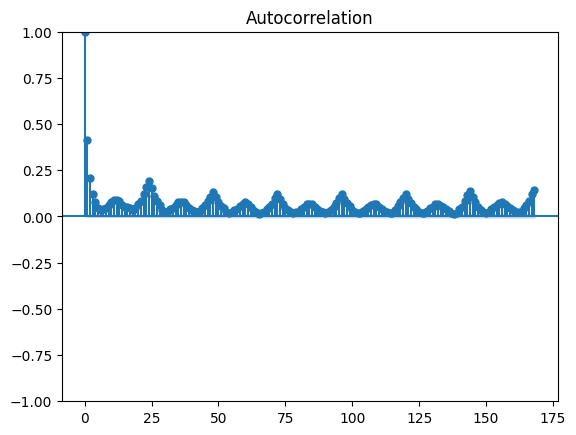

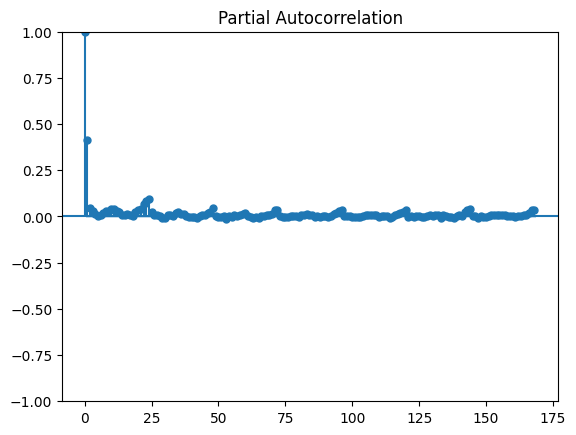

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate ACF plot to determine q for MA
plot_acf(df_imputed['UpwardUsedSecondaryReserveEnergy'], lags=168)
plt.show()

# Generate PACF plot to determine p for AR
plot_pacf(df_imputed['UpwardUsedSecondaryReserveEnergy'], lags=168)
plt.show()


In [3]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_imputed['UpwardUsedSecondaryReserveEnergy'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -22.273727
p-value: 0.000000


In [4]:
# Stationary

In [5]:
P=24
Q=24

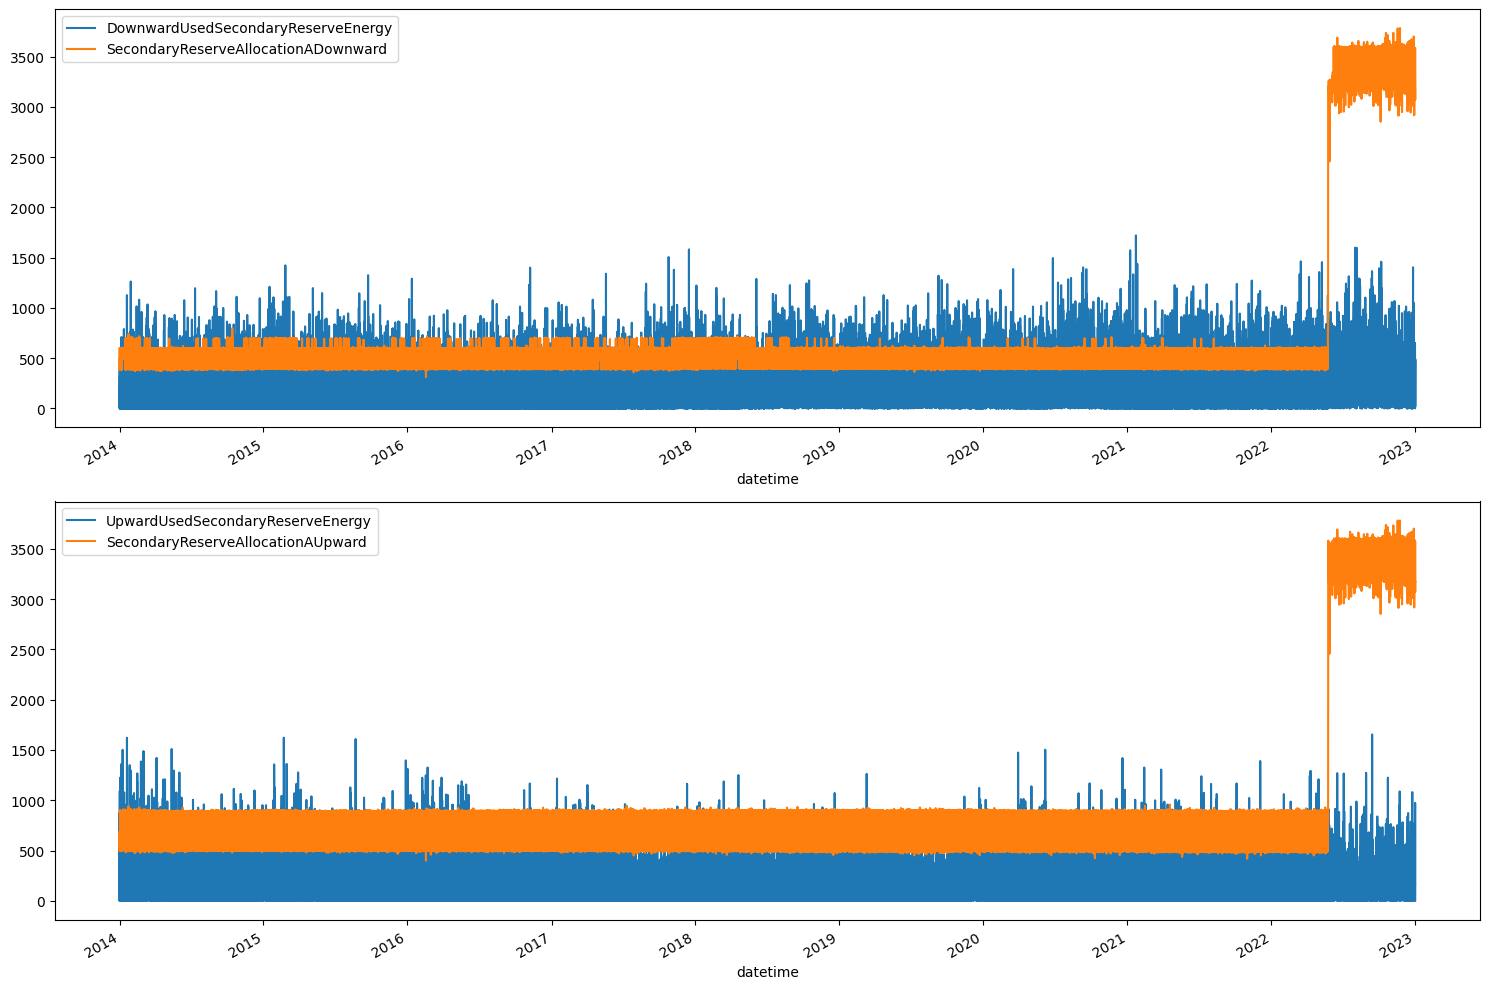

In [6]:
# Benchmark
columns_Y = ["DownwardUsedSecondaryReserveEnergy", "UpwardUsedSecondaryReserveEnergy"]
alloc_column = ["SecondaryReserveAllocationADownward", "SecondaryReserveAllocationAUpward"]

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs = axs.flatten()


for ax, y, a in zip(axs, columns_Y, alloc_column):
    original_dataset[[y,a]].plot(ax=ax)

plt.tight_layout()  # Increase padding
plt.savefig(f'../plots/benchmark.png')




In [7]:
predict_score = prediction_score(original_dataset['UpwardUsedSecondaryReserveEnergy'], original_dataset['SecondaryReserveAllocationAUpward'], original_dataset['SecondaryReserveAllocationAUpward'], "benchmark")


In [8]:
predict_score

{'name': 'benchmark',
 'rmse': 963.1909591866699,
 'abs erro': 53254091.2,
 'erro comp': 'False',
 'r2 score': -26.147637046658637,
 'mape score': 90.44161200506936,
 'alloc missing': 430902.00000000006,
 'alloc surplus': 52823189.2,
 'optimal percentage': 96.35427890526957,
 'better allocation': 96.35427890526957,
 'beter percentage': 100.0}

In [9]:
predict_score = {k:v for k,v in predict_score.items() if not "percentage" in k }
predict_score = {k:v for k,v in predict_score.items() if not "better" in k }
predict_score = {k:[v] for k,v in predict_score.items() if not "name" in k }

In [10]:
pd.DataFrame(predict_score).to_csv('../data/benchmark_scores.csv' ,index=False)

In [11]:
# Split data into train and test
train = df_imputed
test = df_imputed[df_imputed.index.year == 2021]

model_folder = "/home/joao/Documentos/repos/renewable-generation-into-reserve-markets/statistical_models"

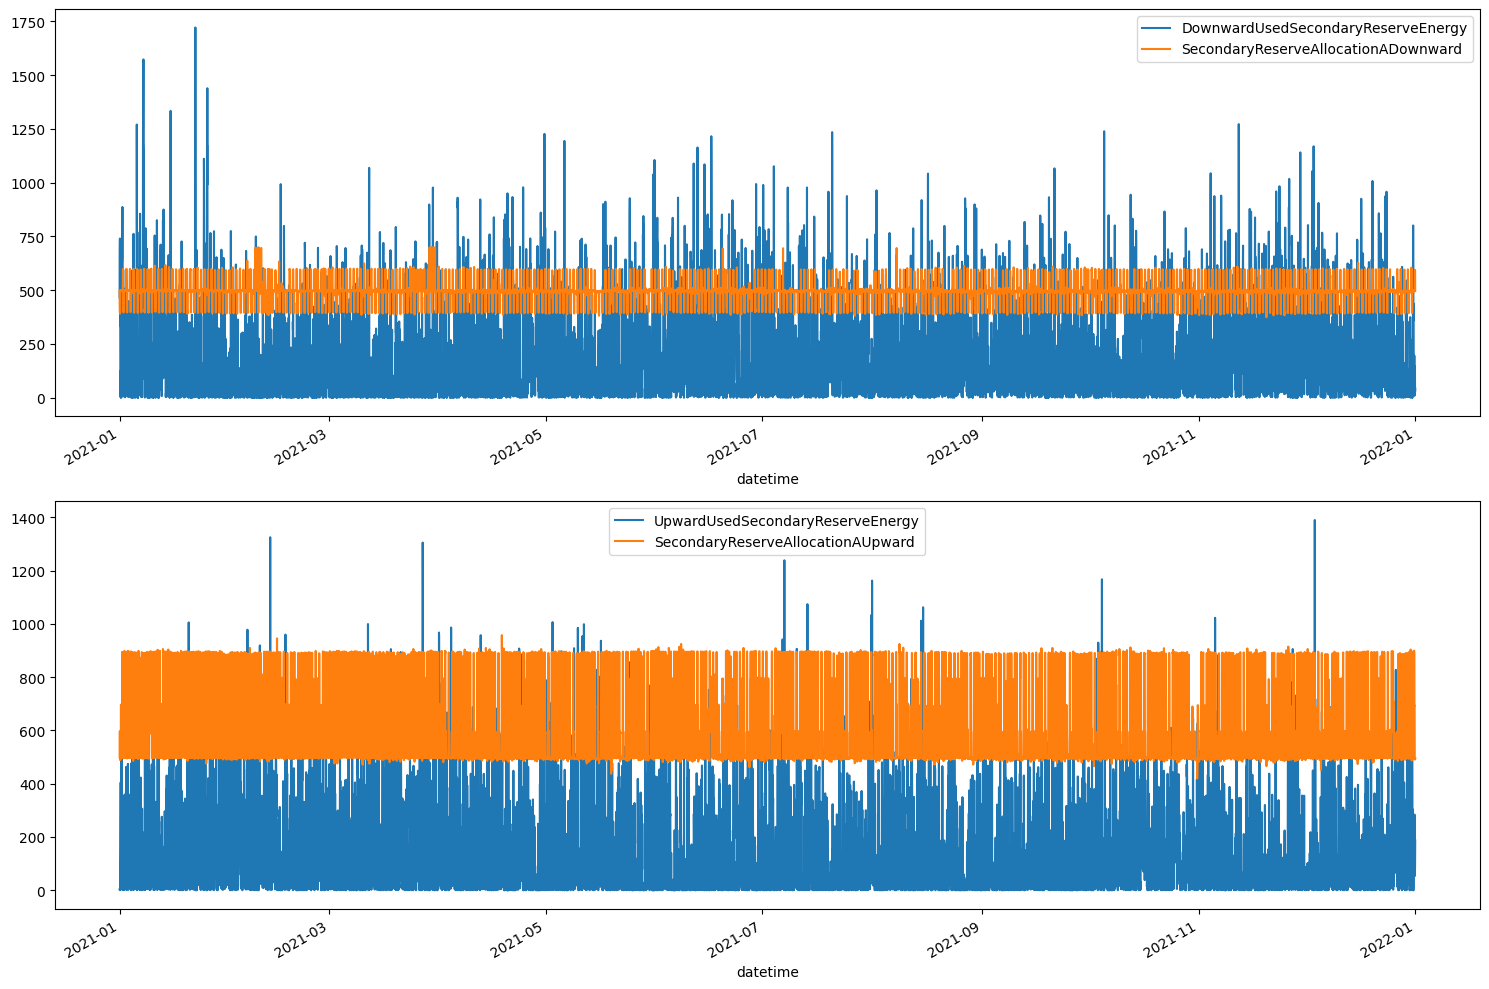

In [12]:
# Benchmark
columns_Y = ["DownwardUsedSecondaryReserveEnergy", "UpwardUsedSecondaryReserveEnergy"]
alloc_column = ["SecondaryReserveAllocationADownward", "SecondaryReserveAllocationAUpward"]

fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs = axs.flatten()


for ax, y, a in zip(axs, columns_Y, alloc_column):
    test[[y,a]].plot(ax=ax)

plt.tight_layout()  # Increase padding
plt.savefig(f'../plots/benchmark_validation.png')




In [13]:
predict_score = prediction_score(test['UpwardUsedSecondaryReserveEnergy'], test['SecondaryReserveAllocationAUpward'], test['SecondaryReserveAllocationAUpward'], "benchmark validation")
predict_score = {k:v for k,v in predict_score.items() if not "percentage" in k }
predict_score = {k:v for k,v in predict_score.items() if not "better" in k }
predict_score = {k:[v] for k,v in predict_score.items() if not "name" in k }

In [14]:
predict_score

{'rmse': [488.55368458838365],
 'abs erro': [3898946.9000000004],
 'erro comp': ['False'],
 'r2 score': [-6.008942605247387],
 'mape score': [85.98375795472323],
 'alloc missing': [57046.4],
 'alloc surplus': [3841900.5]}

In [15]:
pd.DataFrame(predict_score).to_csv('../data/benchmark_validation_scores.csv' ,index=False)

In [17]:


# Function to create, fit, predict and plot a model
def create_fit_predict_plot_model(model, train, test, model_name):
    model_fit = model.fit()
    predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

    model_test_filename = os.path.join(model_folder, f"{model_name}_test.npz")
    model_score_filename = os.path.join(model_folder, f"{model_name}_score.json")



    predict_score = prediction_score(test['UpwardUsedSecondaryReserveEnergy'], predictions, test['SecondaryReserveAllocationAUpward'], model_name)
    save_scores(test['UpwardUsedSecondaryReserveEnergy'], predictions, test['SecondaryReserveAllocationAUpward'], 
                model_test_filename, predict_score, model_score_filename)

    
    fig, ax = plt.subplots()
    #ax.plot(train.index, train['UpwardUsedSecondaryReserveEnergy'], label='Train')
    ax.plot(test.index, test['UpwardUsedSecondaryReserveEnergy'], label='Test')
    ax.plot(predictions.index, predictions, label=model_name)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.title(f'{model_name} Model')
    plt.legend()
    plt.savefig(f'../plots/{model_name}_model.png')


/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/Documentos/repos/renewable-generation-into-reserve-markets/scripts/predictions_scores.py:15: RuntimeWarning: Mean of empty slice
  mape = np.nanmean(np.abs(percentage_error))
/home/joao/Documentos/repos/renewable-generation-into-reserve-markets/scripts/predictions_scores.py:17: RuntimeWarning: Mean of empty slice
  mse= np.nanmean(np.square(erro))


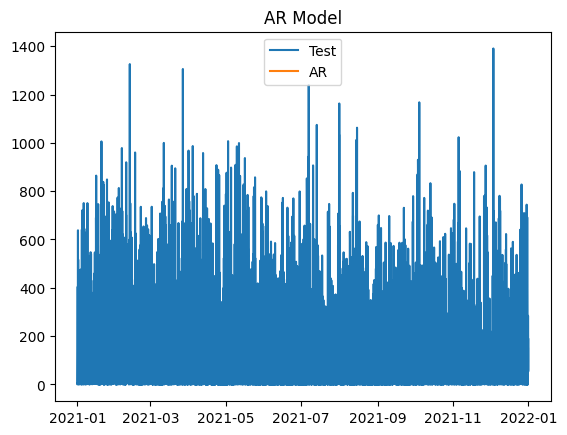

In [12]:

# Create AR model
model_ar = AutoReg(train['UpwardUsedSecondaryReserveEnergy'], lags=P)
create_fit_predict_plot_model(model_ar, train, test, 'AR')



/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

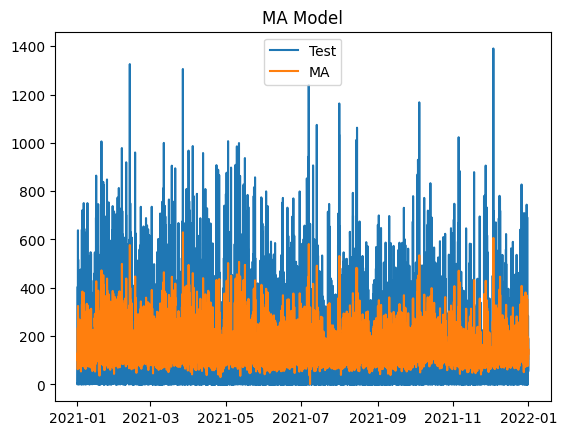

In [13]:
# Create MA model
model_ma = ARIMA(train['UpwardUsedSecondaryReserveEnergy'], order=(0,0,Q))
create_fit_predict_plot_model(model_ma, train, test, 'MA')


/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

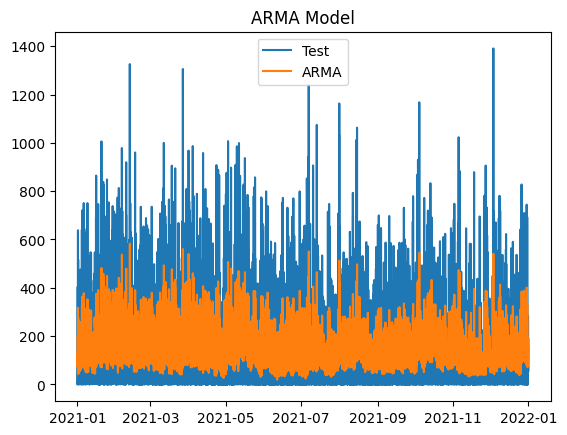

In [14]:

# Create ARMA model
model_arma = ARIMA(train['UpwardUsedSecondaryReserveEnergy'], order=(P,0,Q))
create_fit_predict_plot_model(model_arma, train, test, 'ARMA')


/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

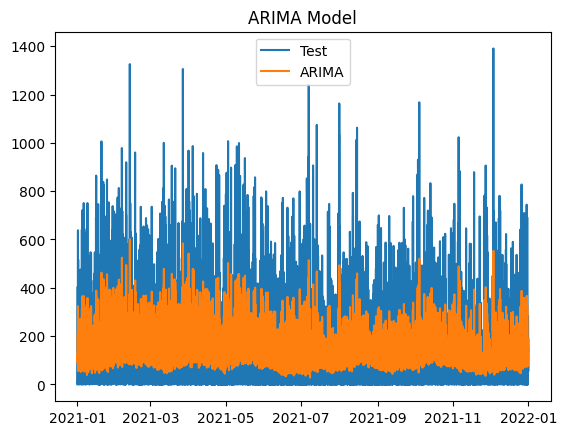

In [18]:

# Create ARIMA model
model_arima = ARIMA(train['UpwardUsedSecondaryReserveEnergy'], order=(P,1,Q))
create_fit_predict_plot_model(model_arima, train, test, 'ARIMA')


/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. for

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.73712D+00    |proj g|=  7.25064D-02


 This problem is unconstrained.



At iterate    5    f=  6.67455D+00    |proj g|=  2.74217D-02

At iterate   10    f=  6.66335D+00    |proj g|=  2.36600D-03

At iterate   15    f=  6.62309D+00    |proj g|=  5.45323D-02

At iterate   20    f=  6.62216D+00    |proj g|=  6.38382D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24    121      3     0     0   4.013D-02   6.622D+00
  F =   6.6219717941745868     

ABNORMAL_TERMINATION_IN_LNSRCH                              


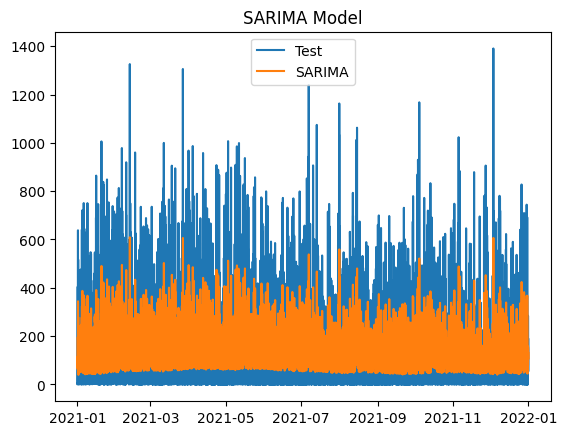

In [19]:

# Create SARIMA model
model_sarima = sm.tsa.statespace.SARIMAX(train['UpwardUsedSecondaryReserveEnergy'], order=(1, 1, 1), seasonal_order=(1,1,1,12))
create_fit_predict_plot_model(model_sarima, train, test, 'SARIMA')

/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/joao/.virtualenvs/tese_cpu/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


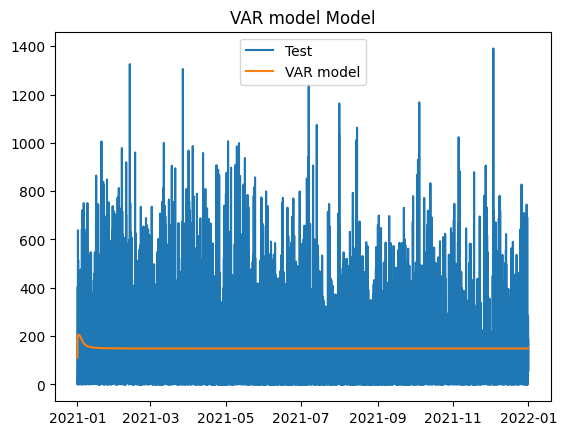

In [20]:
from statsmodels.tsa.vector_ar.var_model import VAR


# Fit VAR model
model = VAR(train)
model_fit = model.fit()
model_name = "VAR model"

# Make prediction
prediction = model_fit.forecast(model_fit.endog, steps=len(test))
# Convert prediction to dataframe
predictions = pd.DataFrame(prediction, index=test.index, columns=test.columns)

model_test_filename = os.path.join(model_folder, f"{model_name}_test.npz")
model_score_filename = os.path.join(model_folder, f"{model_name}_score.json")


predict_score = prediction_score(test['UpwardUsedSecondaryReserveEnergy'], predictions['UpwardUsedSecondaryReserveEnergy'], test['SecondaryReserveAllocationAUpward'], model_name)
save_scores(test['UpwardUsedSecondaryReserveEnergy'], prediction, test['SecondaryReserveAllocationAUpward'], 
            model_test_filename, predict_score, model_score_filename)





fig, ax = plt.subplots()
#ax.plot(train.index, train['UpwardUsedSecondaryReserveEnergy'], label='Train')
ax.plot(test.index, test['UpwardUsedSecondaryReserveEnergy'], label='Test')
ax.plot(predictions.index, predictions['UpwardUsedSecondaryReserveEnergy'], label=model_name)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.title(f'{model_name} Model')
plt.legend()
plt.savefig(f'../plots/{model_name}_model.png')


In [21]:
import json

json_stats = [os.path.join(model_folder,f) for f in os.listdir(model_folder) if "json" in f]

result_dict = {}
results_list = []
for j in json_stats:
    with open(j) as file:
        dic = json.load(file)
    results_list.append(dic)
    for key in dic:
        val = dic[key]
        if not isinstance(val, list):
            val =[val]
        if key not in result_dict:
            result_dict[key]= val
        else:
            result_dict[key]+=val

#res_df = pd.DataFrame(result_dict)
res_df = pd.DataFrame(results_list)
    


In [24]:
res_df.set_index("name").T[["AR","MA","ARMA", "ARIMA","SARIMA", 
                          "VAR model"]].T

,rmse,abs erro,erro comp,r2 score,mape score,alloc missing,alloc surplus,optimal percentage,better allocation,beter percentage
name,,,,,,,,,,
AR,NaN,0.0,True,-0.646446,NaN,NaN,NaN,0.0,0.0,0.0
MA,171.143037,1123214.128971,True,0.139905,17.03786,560507.019008,562707.109963,63.789954,63.789954,86.8379
ARMA,169.985683,1108555.941522,True,0.151499,16.363191,554443.338885,554112.602638,64.041096,64.041096,87.16895
ARIMA,170.126371,1111215.122034,True,0.150093,16.519114,556281.621322,554933.500713,64.02968,64.02968,87.009132
SARIMA,171.8775,1115725.359856,True,0.132507,16.433183,568538.034633,547187.325223,63.447489,63.447489,86.917808
VAR model,184.600552,1253196.024737,True,-0.000677,21.62921,619929.792852,633266.231884,64.817352,64.817352,86.073059


In [28]:
res_df.set_index("name").T[["AR","MA","ARMA", "ARIMA","SARIMA", 
                          "VAR model"]].T.to_csv('../statistical_models/stats_scores.csv' ,index=False)
res_df.set_index("name").T[["AR","MA","ARMA", "ARIMA","SARIMA", 
                          "VAR model"]].T.to_latex("../statistical_models/stats_scores.tex", escape=False,index=False, float_format="%.2f")
